In [1]:
import networkx as nx
import random
from itertools import combinations, product
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

# Class to define multi hop quntum network and functions to solve MDP for serving requests based on the available paths

In [2]:
class QuantumNetwork:
    def __init__(self, num_nodes, edges):
        self.graph = nx.Graph()
        self.graph.add_nodes_from(range(num_nodes))
        self.graph.add_edges_from(edges)
        self.active_edges = set()
        self.avg_rate = defaultdict(float)  # Average rate for each type of request
        self.instantaneous_rate = defaultdict(list)  # Instantaneous rate for each request type



    def generate_all_possible_actions(self, requests, state):
    
        # Create an active graph from the current state
        active_graph = nx.Graph()
        active_graph.add_nodes_from(self.graph.nodes())
        active_graph.add_edges_from(state)
    
        # Collect all possible paths for each request
        request_paths = []
        for request in requests:
            src, tgt, req_type = request
            if nx.has_path(active_graph, src, tgt):
                paths = list(nx.all_simple_paths(active_graph, src, tgt))
            else:
                paths = []  # No paths if source and target are not connected
            request_paths.append((request, paths))
    
        all_path_options = [[path for path in paths] + [[0]] for _, paths in request_paths]
        all_combinations = product(*all_path_options)
    
        unique_actions = set()
    
        
        for combination in all_combinations:
            used_edges = set()  
            action = []
    
            for i, path in enumerate(combination):
                request = request_paths[i][0]  # Get the corresponding request
    
                # If the path is [0], it means no path is chosen for this request
                if path == [0]:
                    action.append((request, 0))
                    continue
    
                path_edges = {(path[j], path[j + 1]) for j in range(len(path) - 1)}
    
                # Check if any edge is already used
                if path_edges & used_edges:

                    action.append((request, 0))
                    continue
    
                action.append((request, path))
                used_edges.update(path_edges)
    
 
            unique_actions.add(tuple((req, tuple(path) if path != 0 else 0) for req, path in action))
    
        valid_actions = [[(req, list(path) if path != 0 else 0) for req, path in action] for action in unique_actions]
        return valid_actions


    def visualize_network(self, active_only=False):
        plt.figure(figsize=(8, 6))
        
        if active_only:
            active_graph = nx.Graph()
            active_graph.add_nodes_from(self.graph.nodes())
            active_graph.add_edges_from(self.active_edges)
            nx.draw(
                active_graph,
                with_labels=True,
                node_color='lightblue',
                edge_color='green',
                node_size=800,
                font_size=10
            )
            plt.title("Active Edges in the Network")
        else:
            nx.draw(
                self.graph,
                with_labels=True,
                node_color='lightblue',
                edge_color='gray',
                node_size=800,
                font_size=10
            )
            plt.title("Multi Hop Quantum Network")
        
        plt.show()

    def attempt_link_creation(self, success_probability=0.5):

        self.active_edges = set()
        for edge in self.graph.edges():
            if random.random() < success_probability:
                self.active_edges.add(edge)

    def get_active_graph(self):
        active_graph = nx.Graph()
        active_graph.add_nodes_from(self.graph.nodes())  # Ensure all nodes are present
        active_graph.add_edges_from(self.active_edges)
        return active_graph



    def generate_all_possible_states(self):

        all_states = []
        all_edges = list(self.graph.edges)
    
        # Generate all subsets of edges
        for num_active in range(len(all_edges) + 1):
            for active_subset in combinations(all_edges, num_active):
                all_states.append(frozenset(active_subset))
        
        return all_states



    def transition_probabilities(self, state, action):

        next_states_probs = defaultdict(float)
        used_edges = set()
    
        # Determine the edges used by the action
        for _, path in action:
            if path == 0:  # No path chosen for this request
                continue
            path_edges = {(path[i], path[i + 1]) for i in range(len(path) - 1)}
            used_edges.update(path_edges)
    

        next_active_edges = set(state) - used_edges
        next_state = frozenset(next_active_edges)
    
        next_states_probs[next_state] = 1.0
    
        return next_states_probs




    

    def solve_mdp_with_value_iteration(self, requests, avg_rate, swapping_probability, gamma=0.9, threshold=1e-4, max_iterations=1000):

        req_type_map = {'A': 0, 'B': 1, 'C': 2}

        # Compute the optimal value function
        states = list(self.generate_all_possible_states())  # Generate all possible states
        V = {state: 0 for state in states}  # Initialize state-value function
    
        for iteration in range(max_iterations):
            delta = 0
            new_V = {}
    
            for state in states:
                max_action_value = -float('inf')
                possible_actions = self.generate_all_possible_actions(requests,state)  # Generate valid actions
    
                for action in possible_actions:
                    # Calculate immediate reward for the action
                    immediate_reward = 0
                    for request, path in action:
                        if path == 0:  # No path selected for this request
                            continue
    
                        inst_rate = self.evaluate_path(path, swapping_probability)
                        req_type = request[2]  # Request type
                        if req_type in req_type_map:  
                           req_type = req_type_map[req_type]  
                        if avg_rate[req_type] > 0:
                            reward = inst_rate / avg_rate[req_type]
                        else:
                            reward = inst_rate
                        immediate_reward += reward
    
                    # Calculate expected future reward
                    expected_next_value = 0
                    next_states_probs = self.transition_probabilities(state, action)
                    for next_state, prob in next_states_probs.items():
                        expected_next_value += prob * V[next_state]
    
     
                    action_value = immediate_reward + gamma * expected_next_value
                    max_action_value = max(max_action_value, action_value)
    
          
                new_V[state] = max_action_value
                delta = max(delta, abs(new_V[state] - V[state]))
    
            V = new_V
            if delta < threshold:
                print(f"Value iteration converged after {iteration + 1} iterations.")
                break
    
        # Derive the optimal policy
        policy = {}
        for state in states:
            best_action = None
            best_value = -float('inf')
            possible_actions = self.generate_all_possible_actions(requests,state)
    
            for action in possible_actions:
                # Calculate immediate reward for the action
                immediate_reward = 0
                for request, path in action:
                    if path == 0:
                        continue
    
                    inst_rate = self.evaluate_path(path, swapping_probability)
                    req_type = request[2]
                    if req_type in req_type_map:  
                       req_type = req_type_map[req_type]  

                    if avg_rate[req_type] > 0:
                        reward = inst_rate / avg_rate[req_type]
                    else:
                        reward = inst_rate
                    immediate_reward += reward
    
               
                expected_next_value = 0
                next_states_probs = self.transition_probabilities(state, action)
                for next_state, prob in next_states_probs.items():
                    expected_next_value += prob * V[next_state]
    
 
                action_value = immediate_reward + gamma * expected_next_value
    
   
                if action_value > best_value:
                    best_value = action_value
                    best_action = action
    
            policy[state] = best_action
    
        return policy



    def evaluate_path(self, path, swapping_probability):

        value = 1.0
        for i in range(1, len(path) - 1):  # Ignore the source and target nodes
            value *= swapping_probability
        return value







def generate_requests(num_nodes, num_type):
    requests=[]
    request_types = [chr(65 + i) for i in range(num_type)]
    for req_type in request_types:
        src, tgt = random.sample(range(num_nodes), 2)  
        requests.append((src, tgt, req_type))
    return requests

# Generate Multi hop QN with "num_nodes" and "requests"

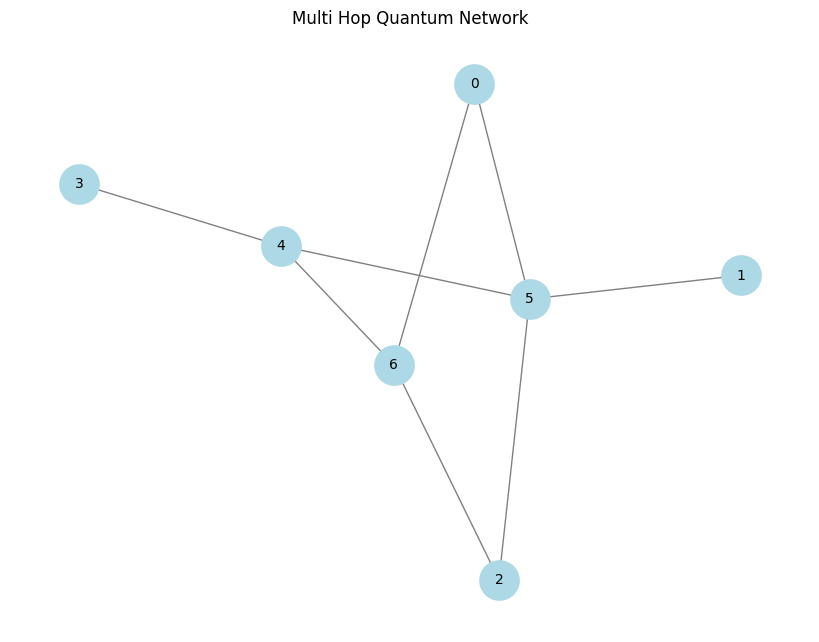

In [3]:
random.seed(42)
np.random.seed(42)

requests =  [(1,3,'A'),(0,2,'B'),(6,3,'C')]  #generate_requests(num_nodes, num_type)
num_nodes = 7
all_edges = list(combinations(range(num_nodes), 2))
random.shuffle(all_edges)
edges = all_edges[:8]  # Randomly select 15 edges




# requests =  [(4,6,'A'),(0,2,'B'),(1,5,'C')]  #generate_requests(num_nodes, num_type)
# num_nodes = 12
# all_edges = list(combinations(range(num_nodes), 2))
# random.shuffle(all_edges)
# edges = all_edges[:16]  # Randomly select 15 edges

quantum_network = QuantumNetwork(num_nodes, edges)


quantum_network.visualize_network()

# quantum_network.attempt_link_creation(success_probability=0.7)

# quantum_network.visualize_network(active_only=True)





# System simulation for Multi hop QN based on optimal policy learned using MDP

In [4]:
# Initialize avg_rate and set parameters
avg_rate_mdp = [100, 100,100]
swapping_probability = 0.8
time_slots = 500
success_probability=0.7
alpha=0.8
log_pf=[]
log_random=[]
avg_rate_random = [100, 100,100]




policy = quantum_network.solve_mdp_with_value_iteration(
        requests=requests,
        avg_rate=avg_rate_mdp,
        swapping_probability=swapping_probability,
        gamma=0.9,
        threshold=1e-9,
        max_iterations=1000
    )

# print(policy)
print("Simulation Started")
for t in range(time_slots):
    # print("average rate",avg_rate)
    # print("current time slot",t)

    quantum_network.attempt_link_creation(success_probability)



    
    # Choose the optimal action based on the current state
    current_state = frozenset(quantum_network.active_edges)
    # print("current state",current_state)


    
    '''
    Serving request based on MDP solution
    '''

    chosen_action = policy.get(current_state, None)
    # print("MDP Action",chosen_action)
    if chosen_action is None:
        print(f"Warning: No valid action found for state {current_state} at time step {t}. Skipping...")
        continue

    
    # Serve requests and update avg_rate
    for request, path in chosen_action:

        req_type = request[2]
        req_type_map = {'A': 0, 'B': 1, 'C': 2}
        req_type_index = req_type_map.get(req_type, -1)
        
        if path == 0:
           if req_type_index >= 0:
              avg_rate_mdp[req_type_index] = (1-alpha)* avg_rate_mdp[req_type_index]
           continue  # No path for this request
        
        inst_rate = quantum_network.evaluate_path(path, swapping_probability)
        if req_type_index >= 0:
            avg_rate_mdp[req_type_index] = alpha*inst_rate+(1-alpha)* avg_rate_mdp[req_type_index] # Update avg_rate based on instantaneous rate

    # Computing the log sum of the average rate for each type of request
    log_sum_pf = np.sum([np.log(avg_rate_mdp[i]) for i in range(len(avg_rate_mdp))])
    log_pf.append(log_sum_pf)

    '''
    Serve requests based by selecting random actions
    '''
    chosen_action_random = random.choice(quantum_network.generate_all_possible_actions(requests,current_state))

    # print("Random Action",chosen_action_random)

    
    # Serve requests and update avg_rate
    for request, path in chosen_action_random:

        req_type = request[2]
        req_type_map = {'A': 0, 'B': 1, 'C': 2}
        req_type_index = req_type_map.get(req_type, -1)
        
        if path == 0:
           if req_type_index >= 0:
              avg_rate_random[req_type_index] = (1-alpha)* avg_rate_random[req_type_index]
           continue  # No path for this request
        
        inst_rate = quantum_network.evaluate_path(path, swapping_probability)
        if req_type_index >= 0:
            avg_rate_random[req_type_index] = alpha*inst_rate+(1-alpha)* avg_rate_random[req_type_index] # Update avg_rate based on instantaneous rate

    # Computing the log sum of the average rate for each type of request
    log_sum_random = np.sum([np.log(avg_rate_random[i]) for i in range(len(avg_rate_random))])
    log_random.append(log_sum_random)

    
    if t>0 and t % 20 == 0:
        print(f"Recomputing MDP at time step {t}...")
        # print("average rate",avg_rate_mdp)
        policy=quantum_network.solve_mdp_with_value_iteration(
            requests=requests,
            avg_rate=avg_rate_mdp,
            swapping_probability=swapping_probability,
            gamma=0.9,
            threshold=1e-9,
            max_iterations=1000
        )

print("Simulation complete. Avg rates over time steps:")
# print(table)


Value iteration converged after 152 iterations.
Simulation Started
Recomputing MDP at time step 20...
Value iteration converged after 204 iterations.
Recomputing MDP at time step 40...
Value iteration converged after 235 iterations.
Recomputing MDP at time step 60...
Value iteration converged after 246 iterations.
Recomputing MDP at time step 80...
Value iteration converged after 214 iterations.
Recomputing MDP at time step 100...
Value iteration converged after 216 iterations.
Recomputing MDP at time step 120...
Value iteration converged after 214 iterations.
Recomputing MDP at time step 140...
Value iteration converged after 200 iterations.
Recomputing MDP at time step 160...
Value iteration converged after 230 iterations.
Recomputing MDP at time step 180...
Value iteration converged after 198 iterations.
Recomputing MDP at time step 200...
Value iteration converged after 246 iterations.
Recomputing MDP at time step 220...
Value iteration converged after 214 iterations.
Recomputing M

In [5]:
def running_average(lst):
    averages = []
    cumulative_sum = 0
    for i, value in enumerate(lst):
        cumulative_sum += value
        averages.append(cumulative_sum / (i + 1))  # (i+1) is the number of elements processed
    return averages





log_pf_run_avg=running_average(log_pf)
log_random_run_avg=running_average(log_random)

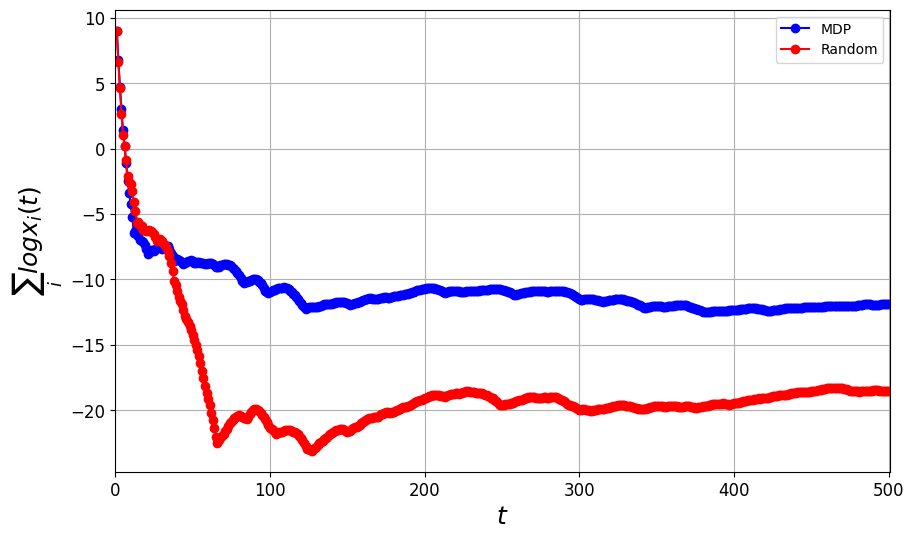

In [6]:
plt.figure(figsize=(10, 6))

plt.plot(range(1, time_slots + 1), log_pf_run_avg, marker='o', linestyle='-', color='b',label="MDP")
plt.plot(range(1, time_slots + 1), log_random_run_avg, marker='o', linestyle='-', color='r',label="Random")
# plt.plot(range(1, time_slots + 1), log_x_greedy, marker='o', linestyle='-', color='g',label="GS")
# plt.title("Sum of Log(Average SKRs) Over Time")
plt.xlabel(r"$t$",fontsize=18)
plt.ylabel(r"$\sum_{i}logx_{i}(t)$",fontsize=18)

plt.legend(fontsize=40)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend()
plt.xlim(0,time_slots + 1)
# plt.ylim(4000,500000)
plt.grid(True)
# plt.savefig('pf_graph.png', format='png', dpi=300)

plt.show()